In [2]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [3]:
con = sqlite3.connect('../data/checking-logs.sqlite')

In [10]:
commits = pd.io.sql.read_sql('''
                        SELECT uid, count(*) as count_commits
                        FROM checker
                        WHERE uid LIKE 'user_%'
                        GROUP BY uid
                        ''', con)
commits.head()

,uid,count_commits
0,user_0,3
1,user_1,84
2,user_10,137
3,user_11,8
4,user_12,93


In [11]:
views = pd.io.sql.read_sql('''
                        SELECT uid, count(*) as count_views
                        FROM pageviews
                        WHERE uid LIKE 'user_%'
                        GROUP BY uid
                        ''', con)
views.head()

,uid,count_views
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3


In [64]:
df_2 = pd.io.sql.read_sql(
    """
    select avg_diff, pageviews, num_commits
    from
    (
        select uid, avg(cast((julianday(test.first_view_ts) - julianday(datetime(deadlines.deadlines, 'unixepoch'))) * 24 as integer)) as avg_diff
        from test left join deadlines on test.labname = deadlines.labs
        where not test.labname = 'project1'
        group by uid
    ) as diff left join
    (
        select uid, count(*) as pageviews
        from pageviews
        group by uid
    ) as views on diff.uid = views.uid left join
    (
        select uid, count(*) as num_commits
        from checker
        group by uid
    ) as commits on diff.uid = commits.uid
    """,
    con
)

In [25]:
test = pd.io.sql.read_sql('''
                        SELECT *
                        FROM test
                        WHERE uid LIKE 'user_%' AND
                        test.labname <> 'project1'
                        GROUP BY uid
                        ''', con, parse_dates=['first_commit_ts', 'first_view_ts'])
test.head()

,index,uid,labname,first_commit_ts,first_view_ts
0,18,user_1,laba04,2020-04-26 17:06:18.462708,2020-04-26 21:53:59.624136
1,14,user_10,laba04,2020-04-25 08:24:52.696624,2020-04-18 12:19:50.182714
2,3,user_14,laba04,2020-04-18 15:14:00.312338,2020-04-18 10:53:52.623447
3,11,user_17,laba04,2020-04-23 14:24:29.947554,2020-04-18 10:56:55.833899
4,20,user_18,laba04,2020-04-26 19:48:11.822365,2020-04-26 22:49:29.243278


In [40]:
test['diff'] = ((test['first_view_ts'] - test['first_commit_ts']).dt.total_seconds()).div(3600)

In [57]:
test.head()

,index,uid,labname,first_commit_ts,first_view_ts,diff
0,18,user_1,laba04,2020-04-26 17:06:18.462708,2020-04-26 21:53:59.624136,4.794767
1,14,user_10,laba04,2020-04-25 08:24:52.696624,2020-04-18 12:19:50.182714,-164.084032
2,3,user_14,laba04,2020-04-18 15:14:00.312338,2020-04-18 10:53:52.623447,-4.335469
3,11,user_17,laba04,2020-04-23 14:24:29.947554,2020-04-18 10:56:55.833899,-123.459476
4,20,user_18,laba04,2020-04-26 19:48:11.822365,2020-04-26 22:49:29.243278,3.021506


In [47]:
df = test.merge(views, how='left', on='uid')\
        .merge(commits, how='left', on='uid')

In [48]:
df.head()

,index,uid,labname,first_commit_ts,first_view_ts,diff,count_views,count_commits
0,18,user_1,laba04,2020-04-26 17:06:18.462708,2020-04-26 21:53:59.624136,4.794767,28,84
1,14,user_10,laba04,2020-04-25 08:24:52.696624,2020-04-18 12:19:50.182714,-164.084032,89,137
2,3,user_14,laba04,2020-04-18 15:14:00.312338,2020-04-18 10:53:52.623447,-4.335469,143,259
3,11,user_17,laba04,2020-04-23 14:24:29.947554,2020-04-18 10:56:55.833899,-123.459476,47,62
4,20,user_18,laba04,2020-04-26 19:48:11.822365,2020-04-26 22:49:29.243278,3.021506,3,66


In [52]:
df.drop(['index', 'uid', 'labname', 'first_commit_ts', 'first_view_ts'], axis=1, inplace=True)

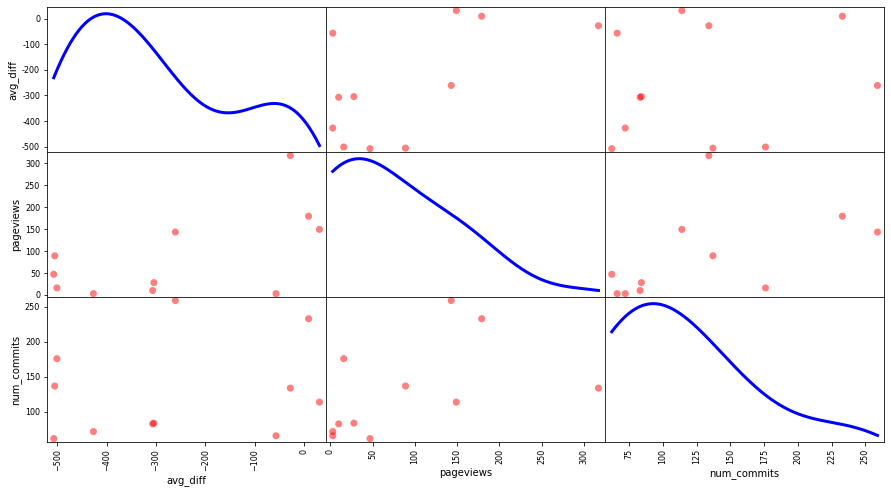

In [67]:
ax = scatter_matrix(df_2, figsize=(15,8), diagonal='kde',
                    density_kwds=dict(color='blue', linewidth=3),
                    s=200, color='red')

Can we say that if a user has a low number of pageviews then they likely
have a low number of commits?

In [ ]:
!!!!!!!!!!!!!

Can we say that if a user has a low number of pageviews then they likely have
a small average difference between the first commit and the lab deadline?

Can we say that there are many users with a low number of commits and a
few – with a high number of commits

Can we say that there are many users with a small average difference and a
few – with a large average difference